---
title: Introduction to Bayesian Inference with Linear Regression
authors:
- name: Aarya Patil
  affiliation: mpia
affiliations:
    - id: mpia
      institution: Max Planck Institute for Astronomy, Königstuhl 17, 69117 Heidelberg, Germany 
      ror: https://ror.org/01vhnrs90
      isni: 0000 0004 0491 677X
      department: Data Science Department
      address: Königstuhl 17
      city: Heidelberg
      country: Germany
      postal_code: 69117
date: 2024-03-26
---

Adapted by Aarya Patil from the notebook in Astro Hack Week 2020

In [1]:
# only necessary if you're running Python 2.7 or lower
from __future__ import print_function, division
from six.moves import range

# import matplotlib and define our alias
from matplotlib import pyplot as plt

# plot figures within the notebook rather than externally
%matplotlib inline

# numpy
import numpy as np

# scipy 
import scipy

# Overview

Although **linear regression** appears simple at first glance, it actually has a surprising amount of depth and is applicable in a bunch of different domains. Most importantly, it provides an accessible way to get a handle on several big concepts in **Bayesian Inference**, including:
- defining objective functions,
- probabilities and likelihoods, 
- estimating parameters,
- the concept of priors, and
- marginalizing over uncertainties.

# Data

Let's generate some mock data below. Don't worry about getting all the details here -- we will come back to them later as we explore how to fit a line better.

In [2]:
def gen_mock_data(seed=123, m=0.875, b=2.523, s=0.523, unc=[0.2, 0.6], N=50):
    """
    Generate `N` mock data points from the line
    with slope `m`, intercept `b`, and
    intrinsic scatter `s` with measurement uncertainties
    uniformly distributed between the values in `unc` using
    a random number generator with the starting `seed`.
    
    """
    
    rstate = np.random.RandomState(seed)
    
    # generate synthetic data
    x = np.sort(3. * rstate.rand(N))  # x values
    y_int = m * x + b  # underlying line
    y = rstate.normal(y_int, s)  # with intrinsic scatter
    yerr = rstate.uniform(unc[0], unc[1], N)  # measurement errors
    yobs = rstate.normal(y, yerr)
    
    return x, yobs, yerr

In [3]:
# generate mock data
x, y, ye = gen_mock_data()

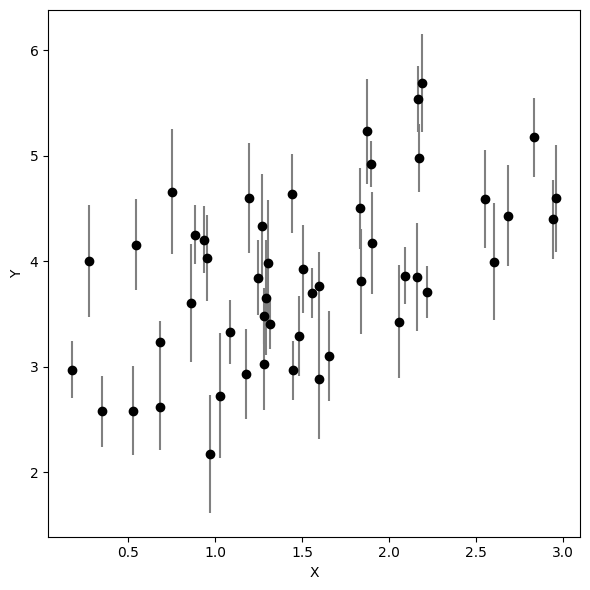

In [4]:
# plot data
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', capsize=0)
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()

# Problem

Our starting goal here is going to be pretty simple: **try to determine a simple linear relationship**. In other words, we want a model like

$$ y = mx + b $$

where $m$ is the slope and $b$ is the $y$-intercept. We will slowly make this model more complicated as we try and model additional features of the data.

# "Chi by Eye"

To start, let's ignore all attempts to make this quantitative. The human brain is actually quite good at fitting models to data, so we can do a **"chi by eye"** process (based on the "chi-squared" statistic we will define later) and just try and benchmark what looks like a reasonable fit. 

**In the cell below, just take a minute or two to see if you can find a "best guess" for the slope and intercept.**

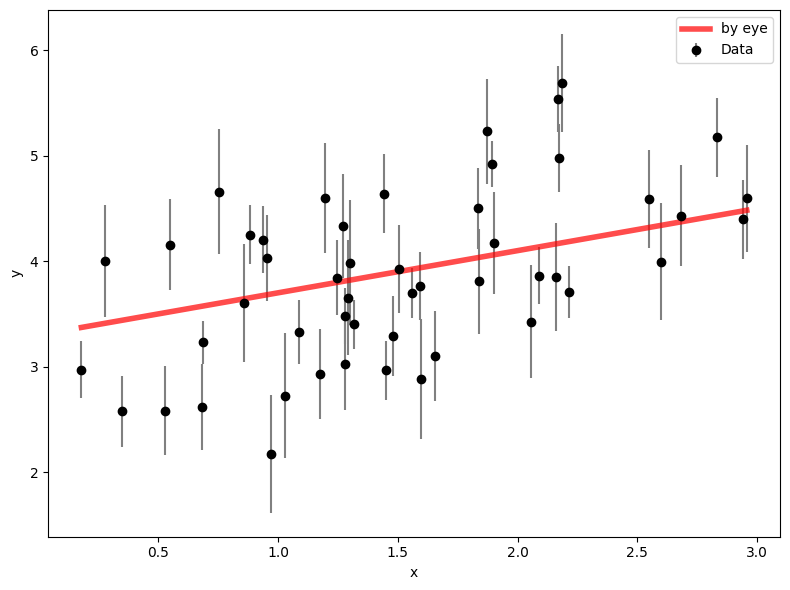

In [5]:
# best estimates of slope and intercept
m_1, b_1 = 0.4, 3.3

# plot data
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
plt.plot(x, m_1 * x + b_1, lw=4, alpha=0.7, color='red',
         label='by eye')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

Your guess should look "reasonable", but you might not feel so good about it. Why? Can you say *why* it's the best fit? How about uncertainties on the slope and intercept?

Part of the difficulty here is that there is no quantitative metric for what makes a fit "good". We will now try to rectify this problem.

# Objective (Loss) Function

One way to define whether a fit is any good is to see how well it actually *predicts* the data it is supposed to be fitting. One way to quantify this involves looking at the residuals

$$ |\Delta y_i| = |y_{i, {\rm pred}} - y_{i}| $$

where $i$ indicates the $i$th datapoint, $y_{i, {\rm pred}} = m x_i + b$ is the prediction from the model and $y_{i}$ is the observed (noisy) value. We are interested in the absolute value because what probably matters is the total error, not whether it's positive or negative. Note that we are currently ignoring the errors.

We would ideally like to have a model that has the smallest residuals for all the points. Let's therefore define a **loss function**:

$$ L(m, b | \{ (x_1, y_1), \dots, (x_N, y_N) \}) = \sum_{i=1}^{N} |\Delta y_i|^p $$

where the $|$ line now indicates "given" or "conditioned on". In other words, what is the loss of a particular slope $m$ and intercept $b$ given the data $\{ (x_1, y_1), \dots, (x_N, y_N) \}$?

$p$ is a power that all residuals are raised to that control how sensitive the loss function is to large and small residuals. Common values for $p$ are often $1 \leq p \leq 2$, with $p=2$ (squaring the residuals) being the most common.

**Filling in the loss function defined below, see how changing the values of the slope and intercept change the loss. Then experiment with how different values of $p$ change the behavior you see.**

In [6]:
# Loss function
def loss(theta, p=2., x=x, y=y):
    """A simple loss function as a function of parameters `theta`."""
    
    m, b = theta  # reassign parameters
    ypred = m * x + b
    resid = np.abs(ypred - y)
    
    return np.sum(resid**p)

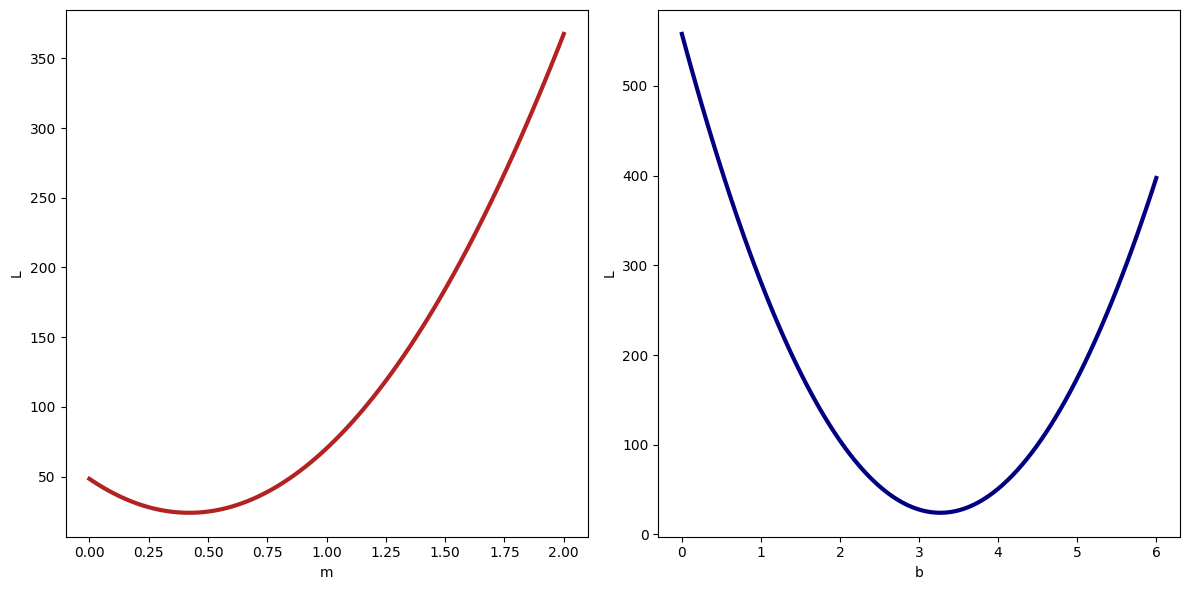

In [7]:
# change m at fixed b
mgrid = np.linspace(0, 2, 100)
loss_m = np.array([loss([m, b_1], p=2.) for m in mgrid])
    
# change b at fixed m
bgrid = np.linspace(0,6, 100)
loss_b = np.array([loss([m_1, b], p=2.) for b in bgrid])


# plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mgrid, loss_m, lw=3, color='firebrick')
plt.xlabel('m')
plt.ylabel('L')
plt.subplot(1, 2, 2)
plt.plot(bgrid, loss_b, lw=3, color='navy')
plt.xlabel('b')
plt.ylabel('L')
plt.tight_layout()

To find the best fit, we want to minimize our loss function. 

**With help from the [documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html), use the `minimize` function from `scipy.optimize` to get the best-fit parameters `theta` based on our loss function `loss`. Quantify the improvement between your initial guess and this new result based on the loss function values. Are they significant? Why or why not?**

If you have extra time, explore how these change as you vary $p$ away from the default value.

In [8]:
from scipy.optimize import minimize

# minimize the loss function
results = minimize(loss, [m_1, b_1])
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 22.952030384848015
        x: [ 6.166e-01  2.942e+00]
      nit: 4
      jac: [ 4.768e-07  0.000e+00]
 hess_inv: [[ 2.056e-02 -3.095e-02]
            [-3.095e-02  5.660e-02]]
     nfev: 18
     njev: 6


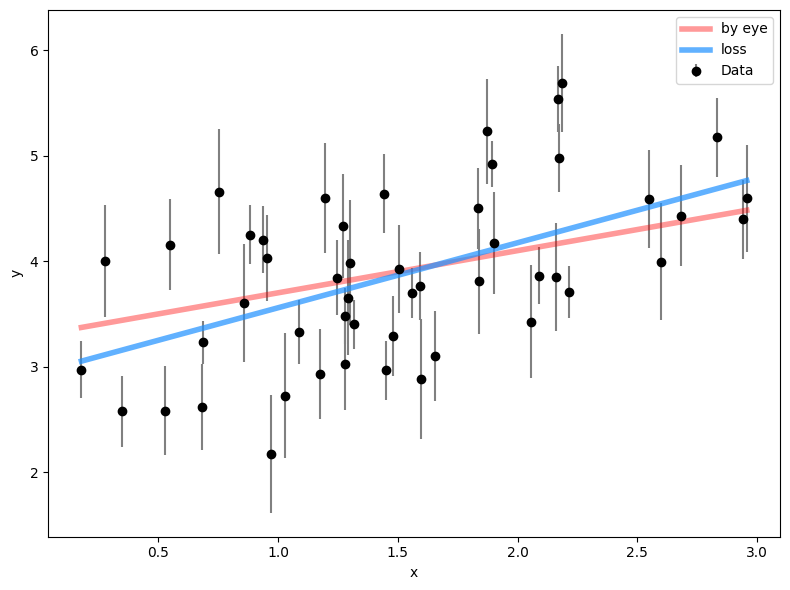

In [9]:
# get best-fit result
m_2, b_2 = results['x']

# plot it against previous results
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
plt.plot(x, m_1 * x + b_1, lw=4, alpha=0.4, color='red',
         label='by eye')
plt.plot(x, m_2 * x + b_2, lw=4, alpha=0.7, color='dodgerblue',
         label='loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

In [10]:
# quantifying the improvement
print('Change in Loss:', loss([m_1, b_1]) - loss([m_2, b_2]))

Change in Loss: 1.192922407460447


# Incorporating Errors with Chi-Square

So far, we haven't tried to incorporate **errors** into our linear regression model. We probably want the fit to take into account whether a point has large or small errors. Points with large errors probably should be "down-weighted" in the fit since they are more uncertain. We can accomplish this be defining the error-normalized resuidual $\chi$:

$$ \chi_i = \left|\frac{\Delta y_i}{\sigma_i}\right| $$

where $\sigma_i$ is the measurement error associated with $y_i$. This should make some intuitive sense: we are just normalizing the residual by the error, so now we are measuring how discrepant the prediction is in units of the error bar for each point.

We can now define the **chi-square statistic** often used in the astronomical literature:

$$ \chi^2(m, b | \{ (x_1, y_1, \sigma_1), \dots, (x_N, y_N, \sigma_N) \}) = \sum_{i=1}^{N} \chi^2_i $$

**Following the example above, define a chi-square function and minimize it. Then quantify how much better the new best-fit model is compared to the previous two. Is this a substantial improvement over what we found earlier? Why or why not?**

In [11]:
# chi2 function
def chi2(theta, x=x, y=y, ye=ye):
    """Chi-square as a function of parameters `theta`."""
    
    m, b = theta  # reassign parameters
    ypred = m * x + b
    resid = ypred - y
    
    return np.sum(resid**2 / ye**2)

In [12]:
# minimize chi2
results = minimize(chi2, [m_2, b_2])
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 146.09510191676458
        x: [ 6.848e-01  2.840e+00]
      nit: 4
      jac: [ 0.000e+00 -5.722e-06]
 hess_inv: [[ 2.860e-03 -4.179e-03]
            [-4.179e-03  7.404e-03]]
     nfev: 18
     njev: 6


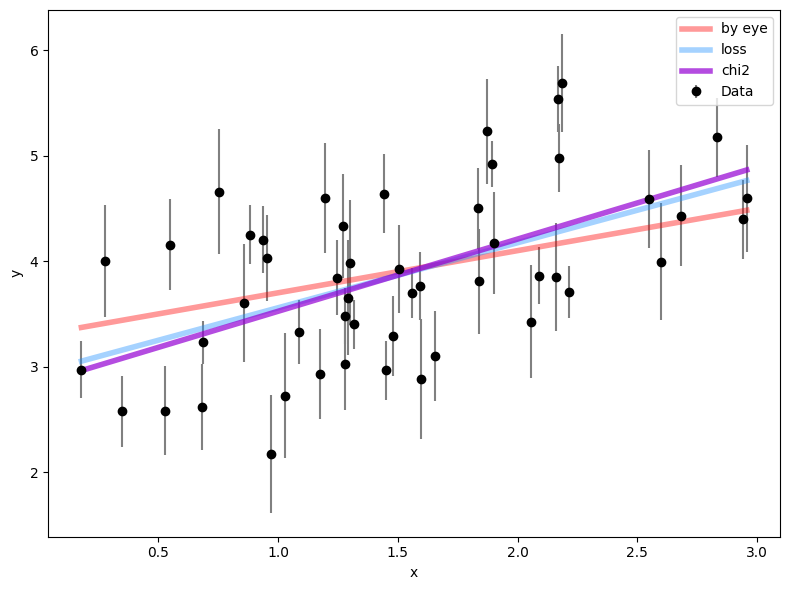

In [13]:
# get best-fit result
m_3, b_3 = results['x']

# plot it against previous results
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
plt.plot(x, m_1 * x + b_1, lw=4, alpha=0.4, color='red',
         label='by eye')
plt.plot(x, m_2 * x + b_2, lw=4, alpha=0.4, color='dodgerblue',
         label='loss')
plt.plot(x, m_3 * x + b_3, lw=4, alpha=0.7, color='darkviolet',
         label='chi2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

In [14]:
# quantifying the improvement
print('Change in chi2:', 
      chi2([m_1, b_1]) - chi2([m_3, b_3]), 
      chi2([m_2, b_2]) - chi2([m_3, b_3]))

Change in chi2: 14.923665349813092 0.8162875786571533


# Defining a Model

We now want to consider an additional source of uncertainty: some amount of **intrinsic scatter** in the fitted relationship. In other words, in addition to the scatter $\sigma_i$ caused by the observational uncertainties, we also want to add on an additional scatter $s_i = s$ that is the same for all points.

How might we do so? Well, maybe we could try something like

$$\chi = \left|\frac{\Delta y_i}{\sigma_i + s}\right|$$

and then write down our $\chi^2$ model as before, but now as a function of $m$, $b$, and $s$. Notice, however, that $\chi^2$ will always get smaller as $s$ increases, since that means the error-normalized residual gets smaller too. Whoops! Maybe we can add on a penalty to disfavor large values? But what would be an appropriate penalty? Maybe something like

$$ \chi^2(m, b, s | \{ (x_1, y_1, \sigma_1), \dots, (x_N, y_N, \sigma_N) \}) = s^2 + \sum_{i=1}^{N} \chi^2_i $$

could work, and we could argue for reasons why it might be reasonable. This basic result, however, reveals a fundamental problem with how we're approached fitting a line so far: we haven't actually defined an underlying **model** for the data.

# Likelihoods

All models start with trying to understand the **data generating process**. In other words, if we wanted to simulate data based on an input set of parameters, how would we do so?

**In the space below, write down the steps we would need to generate data with a given a slope $m$, intercept $b$, and scatter $s$ along with associated positions $x_i$ and uncertainties $\sigma_i$ values.** Don't worry about the details -- just the large conceptual picture is enough.

*Space intentionally left blank*

## Probability Density Functions

To do so, let's start with the observed $y$ values. We have observational errors, but what do those mean? Well, in general it means we assume the observed data follow a **Normal distribution** (also called a "Gaussian") such that the probability that $y_i$ is any particular value follows a **probability density function** of the form

$$ P(y_i|y_{i,{\rm true}}, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[-\frac{1}{2}\frac{(y_{i, {\rm true}} - y_i)^2}{\sigma_i^2}\right] $$

Since our model for the data is $y_{i, {\rm true}} = m x_i + b$, this then gives

$$ P(y_i|m, b, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[-\frac{1}{2}\frac{(m x_i + b - y_i)^2}{\sigma_i^2}\right] $$

Although it is beyond the scope of this notebook to prove, it can be shown that assuming that the intrinsic scatter $s$ is also Gaussian gives the modified result:

$$ P(y_i|m, b, s, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi(\sigma_i^2 + s^2)}} \exp\left[-\frac{1}{2}\frac{(m x_i + b - y_i)^2}{\sigma_i^2 + s^2}\right] $$

## Combining Data

The probability of independent events $A$, $B$, and $C$ all occuring is just the product of their individual probabilities:

$$ P(A, B, C) = P(A) P(B) P(C) $$

The same holds true for data points: if each data point is an independent observation, the total probability is just the individual probabilities for each data point multiplied together. This gives

$$ P(y_1, \dots, y_N|m, b, s, (x_1, \sigma_1), \dots, (x_N, \sigma_N)) = \prod_{i=1}^{N} P(y_i|m, b, s, x_i, \sigma_i) $$

Since the probabilities can get really small really fast, for numerical stability this is almost always re-written in logarithmic form:

$$ \ln P(y_1, \dots, y_N|m, b, s, (x_1, \sigma_1), \dots, (x_N, \sigma_N)) = \sum_{i=1}^{N} \ln P(y_i|m, b, s, x_i, \sigma_i) $$

Notice that, if we explicitly substitute in the Gaussian probability density function, we get this intriguing result:

$$ \ln P(y_1, \dots, y_N|m, b, s, (x_1, \sigma_1), \dots, (x_N, \sigma_N)) = -\frac{1}{2} \sum_{i=1}^{N} \frac{(mx_i + b - y_i)^2}{\sigma_i^2 + s^2} + \ln(2\pi(\sigma_i^2 + s^2)) $$

The first term here looks a lot like our original $\chi^2$ expression, except now with the modified errors. And the second term now looks a lot like a penalty term that disfavors larger $s$ values! So we can see that by explicitly writing out a model, we naturally accomplish our original objective.

# Maximum-Likelihood Estimate (MLE)

The "best-fit" parameters now can be defined as those that **maximize the likelihood** (or, equivalently, minimize the negative of the likelihood).

**Write down a function that computes the (negative) log-likelihood defined above and minimize it. Quantify the difference between these maximum-likelihood results and those derived earlier from the best-fit $\chi^2$. Does the model favor adding in this additional scatter? Why or why not?**

In [15]:
def negloglike(theta, x=x, y=y, ye=ye):
    """(Negative) log-likelihood as a function of parameters `theta`."""
    
    m, b, s = theta  # reassign parameters
    ypred = m * x + b
    resid = ypred - y
    chi2 = resid**2 / (ye**2 + s**2)
    const = np.log(2 * np.pi * (ye**2 + s**2))
    logl = -0.5 * np.sum(chi2 + const)
    
    return -logl

In [16]:
# minimize negative log-likelihood
results = minimize(negloglike, [m_3, b_3, 0.5])
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 50.47672158309011
        x: [ 6.486e-01  2.897e+00  5.095e-01]
      nit: 6
      jac: [ 4.768e-06  2.861e-06  4.768e-07]
 hess_inv: [[ 1.737e-02 -2.594e-02 -2.702e-04]
            [-2.594e-02  4.723e-02  3.457e-04]
            [-2.702e-04  3.457e-04  6.753e-03]]
     nfev: 32
     njev: 8


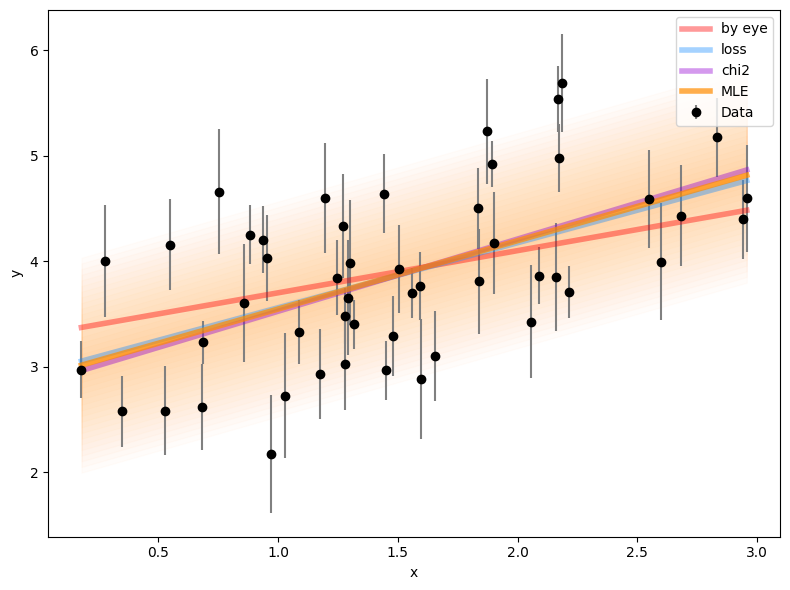

In [17]:
# get best-fit result
m_4, b_4, s_4 = results['x']

# plot it against previous results
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
plt.plot(x, m_1 * x + b_1, lw=4, alpha=0.4, color='red',
         label='by eye')
plt.plot(x, m_2 * x + b_2, lw=4, alpha=0.4, color='dodgerblue',
         label='loss')
plt.plot(x, m_3 * x + b_3, lw=4, alpha=0.4, color='darkviolet',
         label='chi2')
plt.plot(x, m_4 * x + b_4, lw=4, alpha=0.7, color='darkorange', 
         label='MLE')
[plt.fill_between(x, m_4 * x + b_4 + s_4 * n, m_4 * x + b_4 - s_4 * n, 
                  alpha=0.02, color='darkorange')
 for n in np.linspace(0, 2, 20)]
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

In [18]:
# quantifying the improvement
print('Change in loglike:', 
      negloglike([m_3, b_3, 0]) - negloglike([m_4, b_4, s_4]))

Change in loglike: 22.117531960789478


# Posteriors

We now have a working model that can describe the underlying probabilistic processes that generate the data. However, we're still missing one small thing. Notice that, in our earlier notation,

$$ P(A | B) $$

describes the probability of $A$ *given* (i.e. conditioned on) $B$. So our likelihood

$$ P(y_1, \dots, y_N | m, b, s, (x_1, \sigma_1), \dots, (x_N, \sigma_N)) $$

describes something similar: the probability of seeing the observed data $\{ y_1, \dots, y_N\}$ *given* the underlying model parameters $m$, $b$, and $s$ along with the $x_i$ and $\sigma_i$ values. What we *want*, however, is this expression:

$$ P(m, b, s | (x_1, y_1, \sigma_1), \dots, (x_N, y_N, \sigma_N)) $$

This now describes the probability of our model parameters given the data.

Getting at this distribution requires exploiting the fact that probabilities can factor. This allows us to rewrite:

$$ P(A, B) = P(A|B)P(B) = P(B|A)P(A) = P(B, A) \:\:\:\Rightarrow\:\:\: P(B|A) = \frac{P(A|B) P(B)}{P(A)} $$

If we replace $A = {\rm data}$ and $B = {\rm parameters}$, we are left with what's known as **Bayes' Theorem**:

$$ P({\rm parameters} \,|\, {\rm data}) = \frac{P({\rm data}\,|\,{\rm parameters}) \, P({\rm parameters})}{P({\rm data})} $$

Pulling apart this expression:
- The term $P({\rm data}\,|\,{\rm parameters})$, is the **likelihood** that we have been working with already and describes the probability of seeing the data given the model. 
- The term $P({\rm parameters})$ is known as the **prior**: it characterizes our prior knowledge about the parameters is question without seeing the data. 
- The term $P({\rm data})$ is known as the **evidence** (or marginal likelihood). Since this is just a constant, most often we can just ignore it.
- Finally, the left-hand side $P({\rm parameters} \,|\, {\rm data})$ is known as the **posterior** since it combines the prior and the likelihood together.

## Priors

A central component of Bayesian inference is the prior, which describes our prior knowledge of the parameters. This is where all of the power (and drawbacks) of Bayesian inference comes from, since the priors can dramatically affect the analysis.

As an example, consider priors on the components that are independent and Gaussian, analagous to our data. If we wrote out the new log-posterior, we would then get:

$$ \ln P(m, b, s | (x_1, y_1, \sigma_1), \dots, (x_N, y_N, \sigma_N)) = \left\{-\frac{1}{2} \sum_{i=1}^{N} \frac{(mx_i + b - y_i)^2}{\sigma_i^2 + s^2} + \ln(2\pi(\sigma_i^2 + s^2)) \right\} + \left\{-\frac{1}{2} \sum_{j=\{m,b,s\}} \frac{(j - \mu_j)^2}{\sigma_j^2} + \ln(2\pi\sigma_j^2)\right\} + C $$

where $C$ is again a constant that we can ignore. We can see the priors correspond to additional penalty terms on the parameters that function like additional data points.

# *Maximum-a-Posteriori* (MAP) Estimate

Finally, we can now find our parameter estimates with the highest log-posterior values, known as the **maximum-a-posteriori** (MAP) estimate.

**Using the functional form above, define a Gaussian log-prior over each of the three parameters by specifying a given mean and standard deviation. Then, minimize the (negative) log-posterior.**

In [19]:
prior_means = np.array([1., 3., 0.5])  # m, b, s
prior_stds = np.array([0.25, 0.5, 0.15])  # m, b, s

def neglogprior(theta, mean=prior_means, std=prior_stds):
    """(Negative) log-prior as a function of parameters `theta`."""
    
    chi2 = (theta - mean)**2 / std**2
    const = np.log(2. * np.pi * std**2)
    logp = -0.5 * np.sum(chi2 + const)
    
    return -logp

def neglogpost(theta, x=x, y=y, ye=ye, mean=prior_means, std=prior_stds):
    """(Negative) log-posterior as a function of parameters `theta`."""
    
    m, b, s = theta  # reassign parameters
    logp = -neglogprior(theta, mean=mean, std=std)
    logl = -negloglike(theta, x=x, y=y, ye=ye)
    
    return -(logl + logp)

In [20]:
# minimize negative log-likelihood
results = minimize(neglogpost, [m_4, b_4, s_4])
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 50.11148436191087
        x: [ 7.103e-01  2.811e+00  5.075e-01]
      nit: 8
      jac: [ 0.000e+00  9.537e-07 -1.431e-06]
 hess_inv: [[ 1.221e-02 -1.761e-02  2.954e-04]
            [-1.761e-02  3.354e-02 -3.595e-04]
            [ 2.954e-04 -3.595e-04  5.239e-03]]
     nfev: 44
     njev: 11


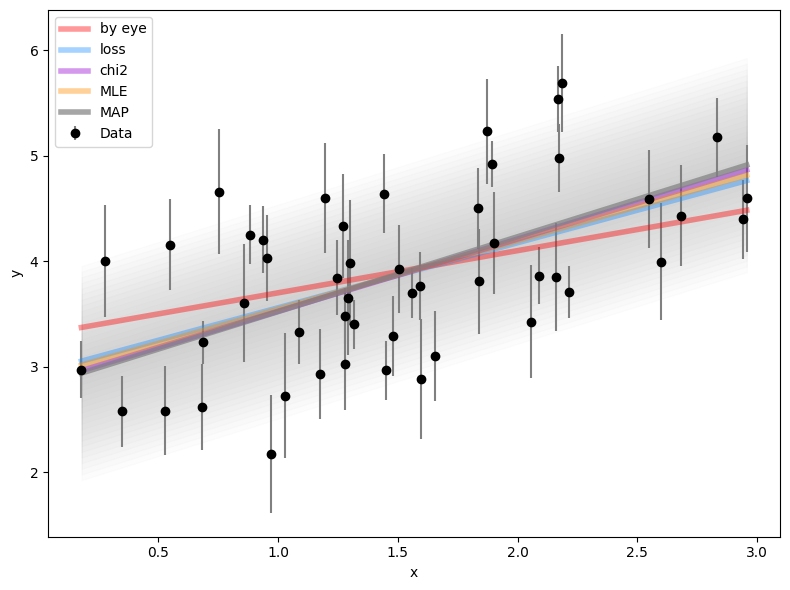

In [21]:
# get best-fit result
m_5, b_5, s_5 = results['x']

# plot it against previous results
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
plt.plot(x, m_1 * x + b_1, lw=4, alpha=0.4, color='red',
         label='by eye')
plt.plot(x, m_2 * x + b_2, lw=4, alpha=0.4, color='dodgerblue',
         label='loss')
plt.plot(x, m_3 * x + b_3, lw=4, alpha=0.4, color='darkviolet',
         label='chi2')
plt.plot(x, m_4 * x + b_4, lw=4, alpha=0.4, color='darkorange', 
         label='MLE')
plt.plot(x, m_5 * x + b_5, lw=4, alpha=0.7, color='gray', 
         label='MAP')
[plt.fill_between(x, m_5 * x + b_5 + s_5 * n, m_5 * x + b_5 - s_5 * n, 
                  alpha=0.02, color='gray')
 for n in np.linspace(0, 2, 20)]
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()

# Parameter Uncertainties

In addition to just providing a best-fit solution, the posterior distribution now quantifies just how much more likely one model is than another. While exploring this fully is beyond the scope of this introduction, one neat result of using a properly defined probability as the function to be minimize is that the minimization routine provides estimates of the parameter errors via the `hess_inv` item in the output results dictionary. This allows us to visualize how our final posterior distribution compares to our input priors, which is shown below.

**Using the plots below, explore how changing the priors impacts the inferred solution. At what point do the best-fit values and errors become "prior-dominated" (prior largely determines the results)? At what point do they become "likelihood-dominated" (prior has little impact on the result)?**

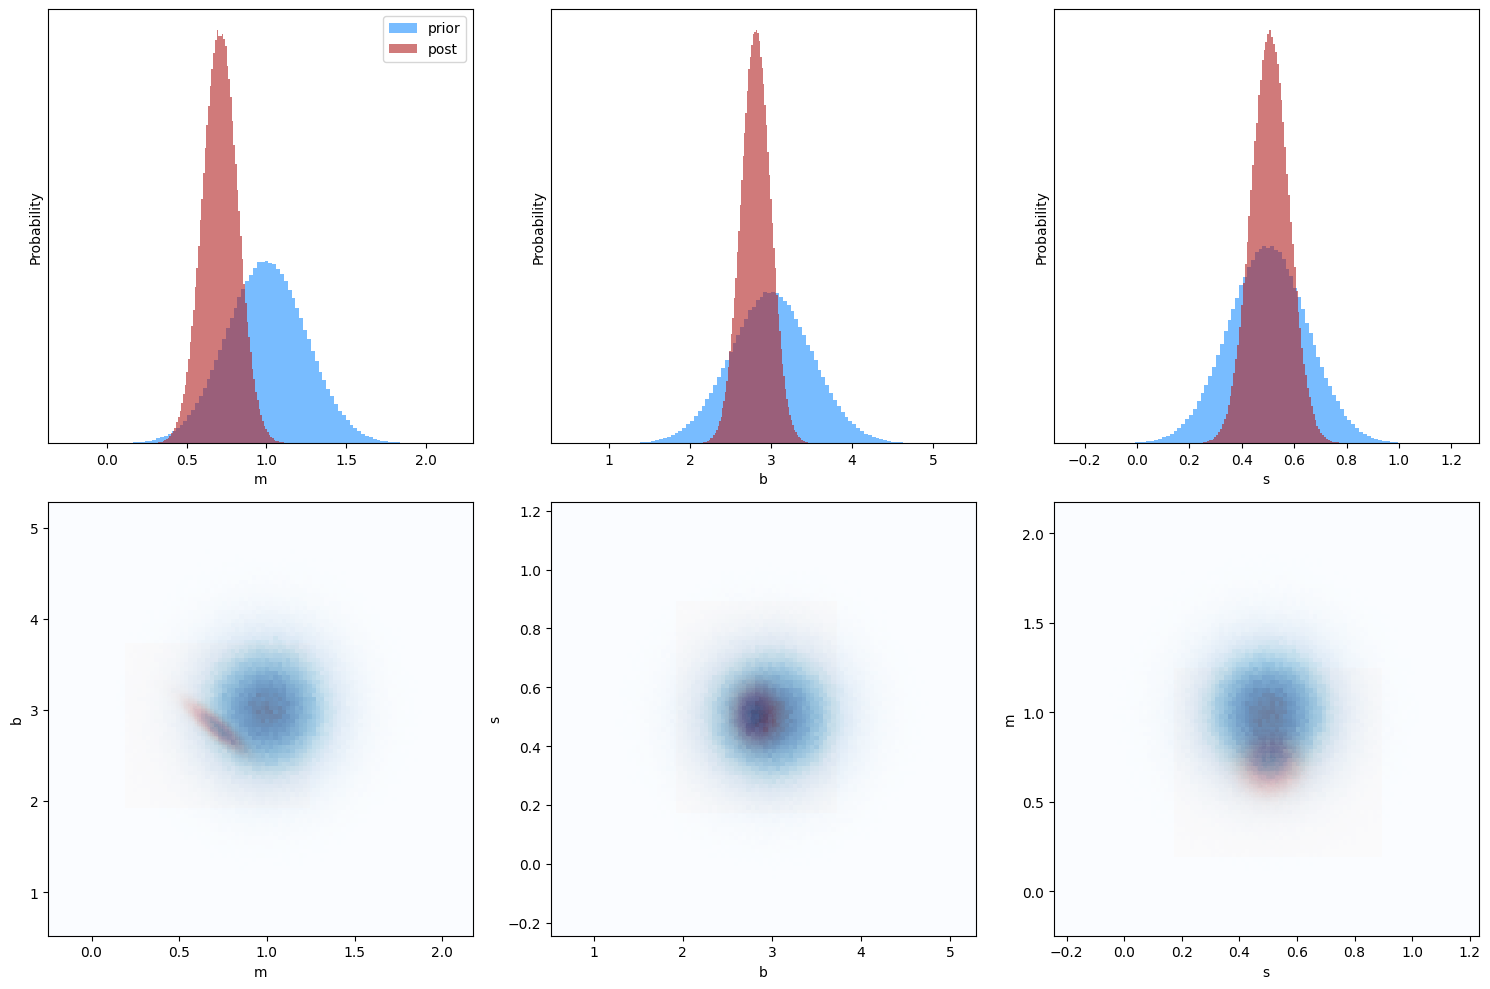

In [22]:
n = int(1e6)

# generate prior samples
m_prior, b_prior, s_prior = np.random.multivariate_normal(prior_means, 
                                                          np.diag(prior_stds**2), 
                                                          size=n).T

# generate posterior samples
m_post, b_post, s_post = np.random.multivariate_normal(results['x'], 
                                                       results['hess_inv'], 
                                                       size=n).T

# generate 1-D histograms of priors vs posteriors
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.hist(m_prior, 100, density=True, label='prior',
         color='dodgerblue', alpha=0.6)
plt.hist(m_post, 100, density=True, label='post',
         color='firebrick', alpha=0.6)
plt.xlabel('m')
plt.ylabel('Probability')
plt.yticks([])
plt.legend()
plt.subplot(2, 3, 2)
plt.hist(b_prior, 100, density=True, label='prior',
         color='dodgerblue', alpha=0.6)
plt.hist(b_post, 100, density=True, label='post',
         color='firebrick', alpha=0.6)
plt.xlabel('b')
plt.ylabel('Probability')
plt.yticks([])
plt.subplot(2, 3, 3)
plt.hist(s_prior, 100, density=True, label='prior',
         color='dodgerblue', alpha=0.6)
plt.hist(s_post, 100, density=True, label='post',
         color='firebrick', alpha=0.6)
plt.xlabel('s')
plt.ylabel('Probability')
plt.yticks([])
plt.tight_layout()

# generate 2-D histograms of posteriors
plt.subplot(2, 3, 4)
plt.hist2d(m_post, b_post, 100,
           cmap='Reds', alpha=0.6)
plt.hist2d(m_prior, b_prior, 100,
           cmap='Blues', alpha=0.6)
plt.xlabel('m')
plt.ylabel('b')
plt.subplot(2, 3, 5)
plt.hist2d(b_post, s_post, 100,
           cmap='Reds', alpha=0.6)
plt.hist2d(b_prior, s_prior, 100,
           cmap='Blues', alpha=0.6)
plt.xlabel('b')
plt.ylabel('s')
plt.subplot(2, 3, 6)
plt.hist2d(s_post, m_post, 100,
           cmap='Reds', alpha=0.6)
plt.hist2d(s_prior, m_prior, 100,
           cmap='Blues', alpha=0.6)
plt.xlabel('s')
plt.ylabel('m')
plt.tight_layout()

One additional way to view the results is to generate the **posterior predictive**. This just means to actually see what the different fits look like overplotted on top of the data (i.e. the predictions *marginalized over* the parameter uncertainties). **If you have extra time, try visualizing this uncertainty by overplotting the parameters generated above over the data points.**

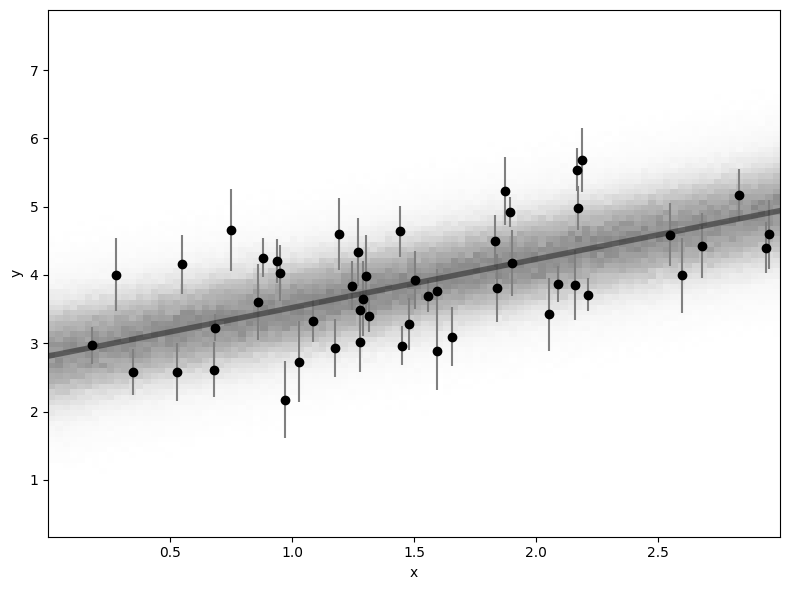

In [23]:
# plot posterior predictive
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=ye, fmt="ko", ecolor='gray', 
             capsize=0, label='Data')
xs = np.sort(np.random.uniform(0, 3, n))
ys = np.random.normal(m_post * xs + b_post, s_post)
plt.hist2d(xs, ys, 100, cmap='Greys', alpha=0.5)
plt.plot(xs, m_5 * xs + b_5, lw=4, alpha=0.4, color='black', 
         label='MAP')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

# Model Comparison

One way to compare models is by computing the Bayesian Information Criterion (BIC) as done below. Note that p is the number of parameters in the model, n is the number of observations, and the last term is $-2 \log L(\hat{\Theta})$ where
$\hat{\Theta}$ is the MLE of $\Theta$.

In [28]:
p = 3
BIC = p * np.log(n) + 2*negloglike([m_4, b_4, s_4])

Try other ways of comparing models below: